# Taking Observations

### Wave propagation 

In [38]:
import os
import numpy as np

In [39]:
from medis.medis_main import RunMedis  # this is the top level function
from medis.plot_tools import quick2D, grid  # plotting single images or a grid of images
from medis.params import params  # this is where all the default parameters are stored
from medis.utils import dprint  # this is just a useful function

Overwrite the parameters we care about

In [ ]:
params['sp'].save_to_disk = False  # having this off is useful initially until we start running full sims
params['sp'].verbose = True
params['sp'].debug = True  # this will show the results at every optic for the star at the shortest wavelength
params['sp'].numframes = 1  # total number of time frames
params['sp'].sample_time = 0.5e-3  # time between time frames
params['sp'].beam_ratio = 0.1  # low value supresses the reflections in the focal plane
params['sp'].save_list = np.array(['atmosphere','detector'])

params['ap'].companion_xy = [[0.5,0]]  # this is 50 mas separation
params['ap'].contrast = [1e-3]  # this is 50 mas separation
params['ap'].companion = True
params['ap'].n_wvl_init = 1  # single band
params['tp'].cg_type = 'Solid'  # occulter type
params['tp'].ao_act = 50  # number of actuators along an axis
params['tp'].satelite_speck = False  # object to close to care about these
params['tp'].prescription = 'general_telescope' # 'Subaru_SCExAO'  # lets use general for now
params['tp'].obscure = False  # spiders and M2 obscurations off for now
params['tp'].use_ao = True

TESTDIR = 'demo'

First lets just intialise a simulation that generates ideal electric fields (no photon noise or dead pixels etc) for this system. This will create the top "test" directory if it does not already exist. If it does exist the params file will be checked against the requested parameters to see if they match (has not been fully verified yet)

In [41]:
sim = RunMedis(params=params, name=f'{TESTDIR}/justfields', product='fields')


	 Astro_params
{'C_spec': 1.5,
 'companion': True,
 'companion_xy': [[0.5, 0]],
 'contrast': [0.001],
 'interp_wvl': True,
 'n_wvl_final': 1,
 'n_wvl_init': 1,
 'star_flux': 1000000000.0,
 'wvl_range': array([8.0e-07, 1.5e-06])}

	 Telescope_params
{'abertime': 0.5,
 'ao_act': 50,
 'array_size': array([129, 129]),
 'cg_size': 3,
 'cg_size_units': 'l/D',
 'cg_type': 'Solid',
 'detector': 'ideal',
 'entrance_d': 5,
 'fit_dm': True,
 'fl_cg_lens': 1000,
 'flen_primary': 25,
 'fnum_primary': 12,
 'legs_frac': 0.03,
 'lens_params': [{'aber_vals': [5e-18, 2.0, 3.1],
                  'diam': 0.2,
                  'dist': 1.345,
                  'focal_length': 1.2,
                  'name': 'CPA'},
                 {'aber_vals': [5e-18, 2.0, 3.1],
                  'diam': 0.2,
                  'dist': 1.345,
                  'focal_length': 1.2,
                  'name': 'NCPA'}],
 'lyot_size': 0.75,
 'obscure': False,
 'piston_error': False,
 'pix_shift': [0, 0],
 'prescription': 'gen

Calling sim will begin the observation that generates the fields ndarray. It will create all the directories, atmosphere maps, aberration maps, coronagraph maps and check if the simulation needs to be chunked to fit into the dynamic memory or not

since params['sp'].debug is True it will produce lots of plots


Initialising new telescope instance

Using prescription /Users/dodkins/PythonProjects/MEDIS++/simulations/general_telescope/general_telescope.py
Copying over prescription /Users/dodkins/PythonProjects/MEDIS++/simulations/general_telescope/general_telescope.py
MEDIS++/medis/atmosphere.py:32 - Making New Atmosphere Model
MEDIS++/medis/atmosphere.py:68 - atmos file = /Users/dodkins/MKIDSim/demo/justfields/atmos/gridsz512_bmratio0.1_tsteps1/atmos_t0.000_single_wvl8.000e-07.fits
MEDIS++/medis/aberrations.py:50 - Generating optic aberration maps using Proper at directory /Users/dodkins/MKIDSim/demo/justfields/aberrations/gridsz512_bmratio0.1_tsteps1
pyFFTW not found, using Numpy FT.
MEDIS++/medis/aberrations.py:50 - Generating optic aberration maps using Proper at directory /Users/dodkins/MKIDSim/demo/justfields/aberrations/gridsz512_bmratio0.1_tsteps1
pyFFTW not found, using Numpy FT.
Each timestep is predicted to be 4.194304 MB, requiring sim to be split into 2384.0 time chunks
File total

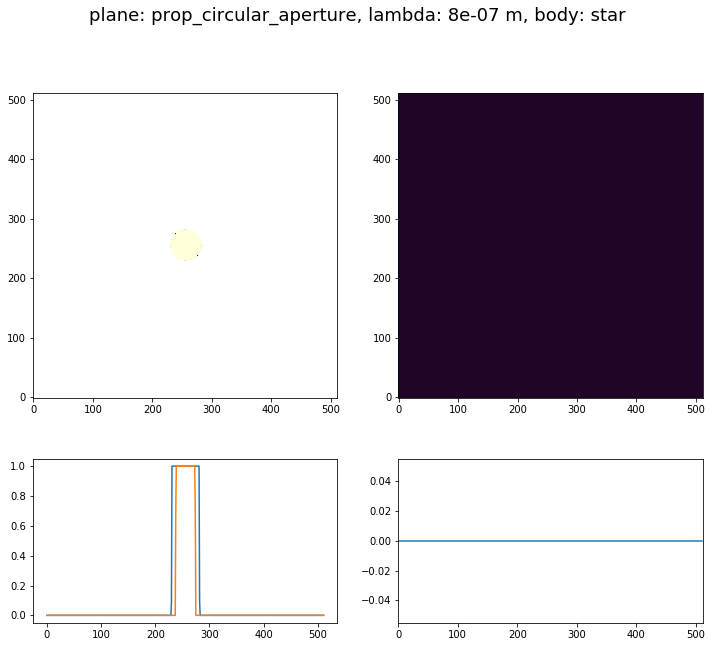

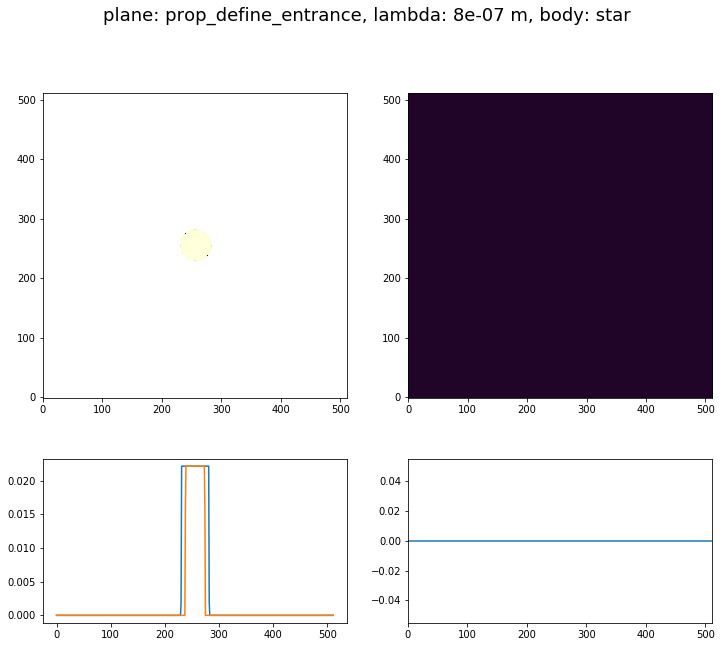

MEDIS++/medis/atmosphere.py:104 - Atmos map applied is /Users/dodkins/MKIDSim/demo/justfields/atmos/gridsz512_bmratio0.1_tsteps1/atmos_t0.000_single_wvl8.000e-07.fits
MEDIS++/medis/atmosphere.py:104 - Atmos map applied is /Users/dodkins/MKIDSim/demo/justfields/atmos/gridsz512_bmratio0.1_tsteps1/atmos_t0.000_single_wvl8.000e-07.fits


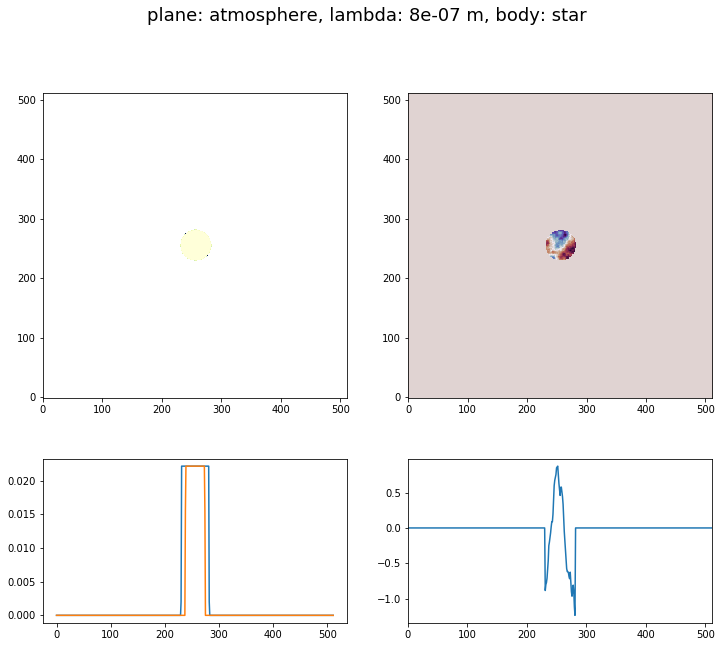

Zeroing outside the beam after atmosphere
MEDIS++/medis/optics.py:176 - saving plane at atmosphere


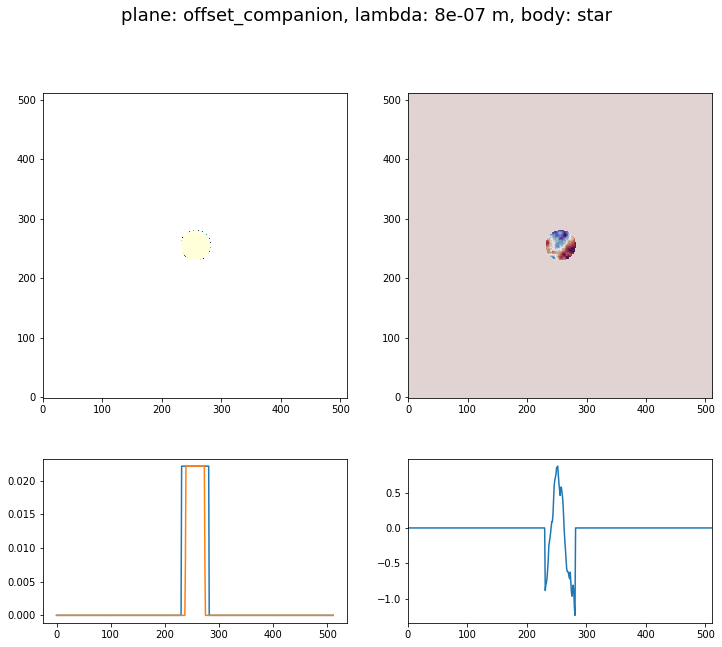

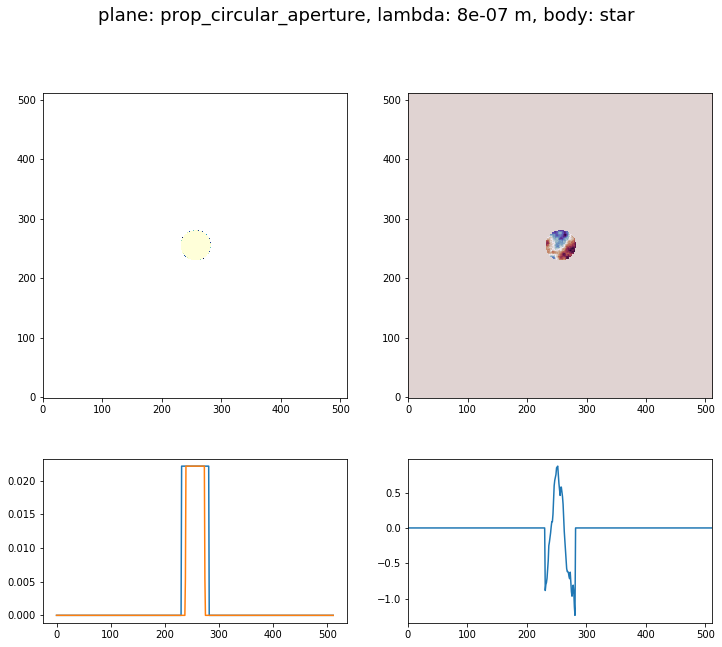

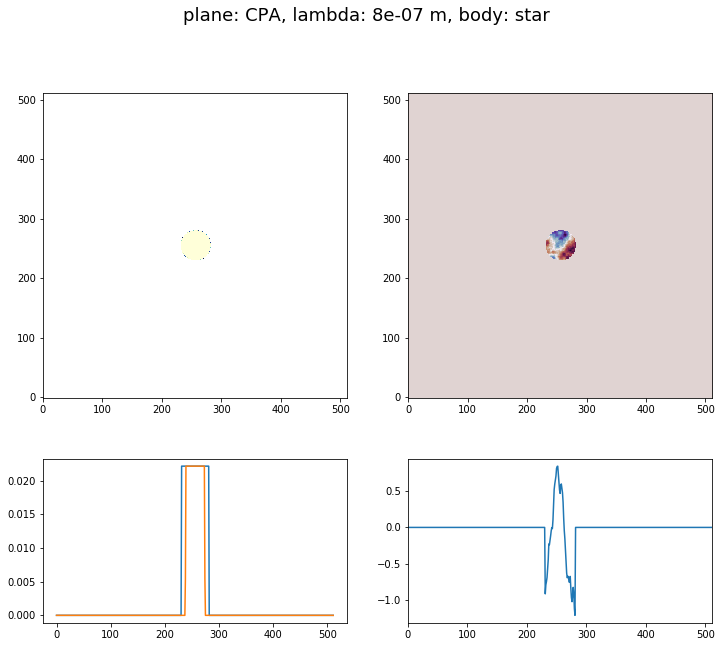

Zeroing outside the beam after CPA


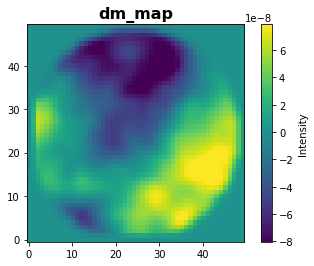

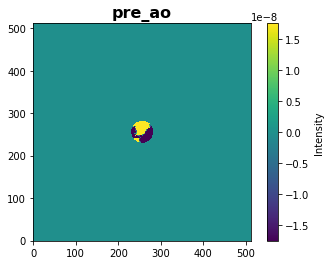

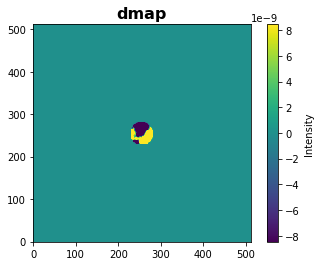

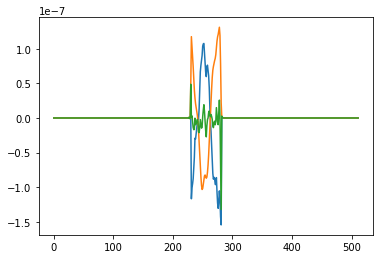

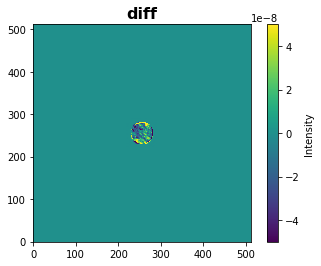

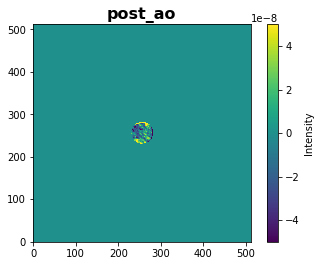

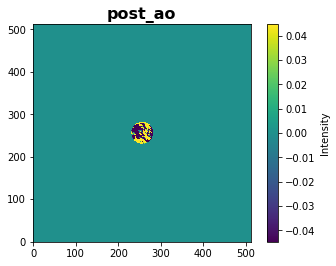

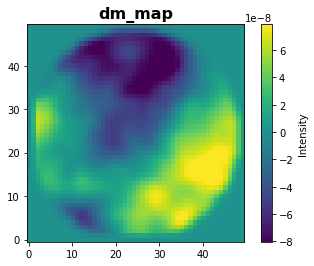

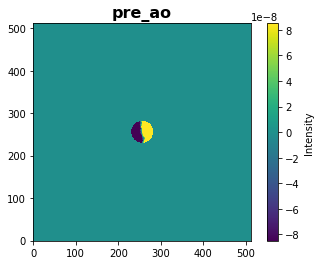

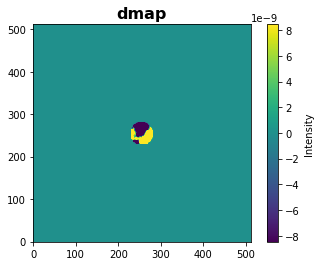

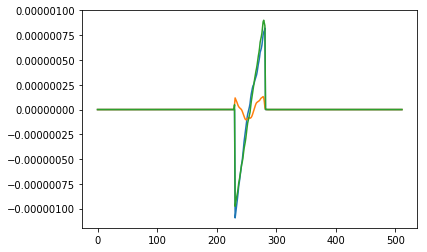

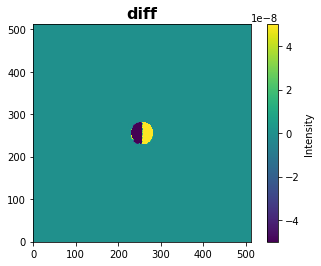

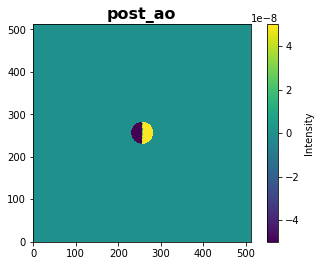

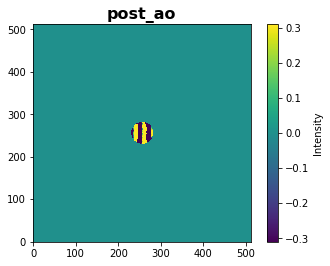

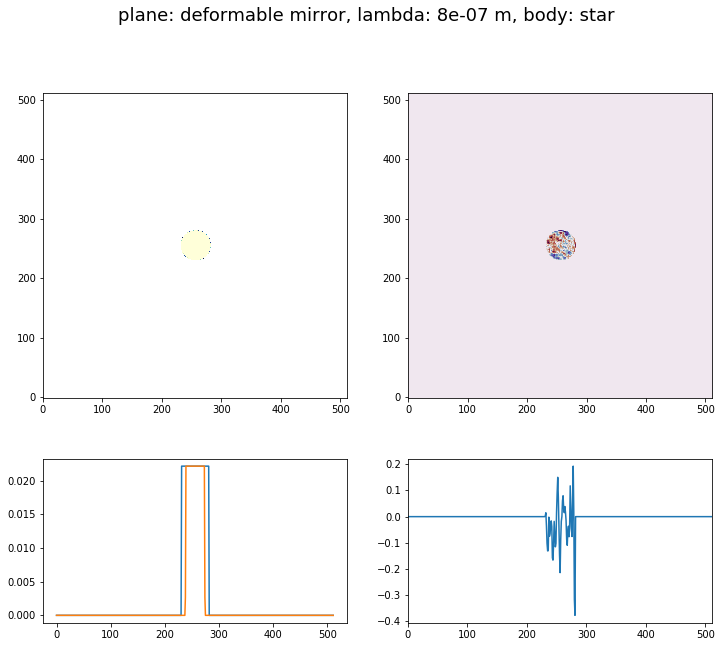

Zeroing outside the beam after deformable mirror


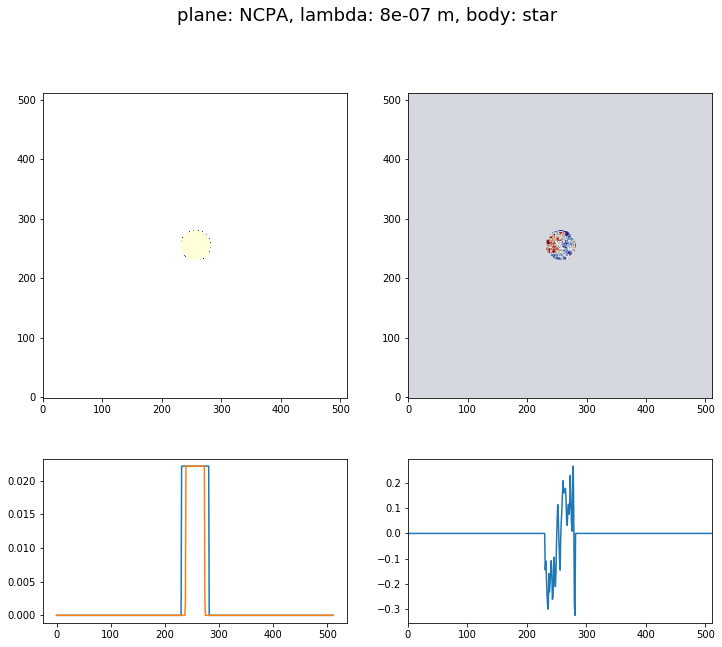

Zeroing outside the beam after NCPA


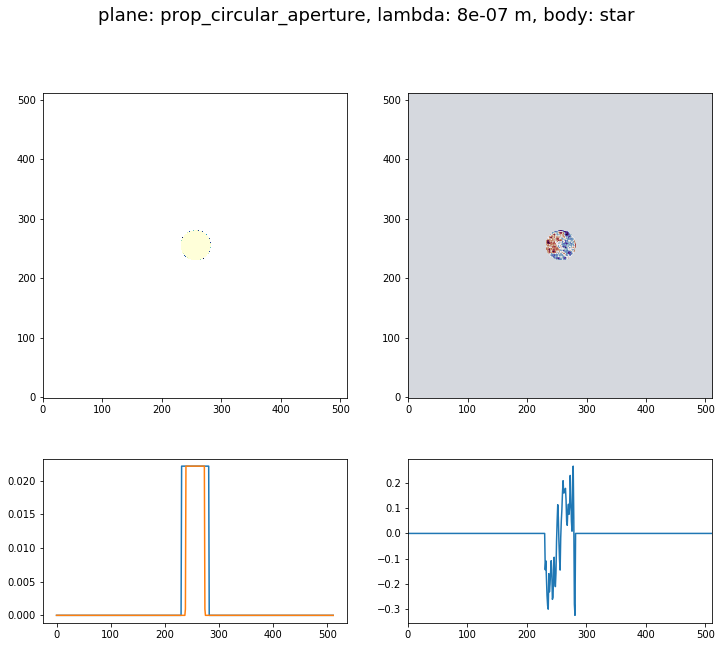

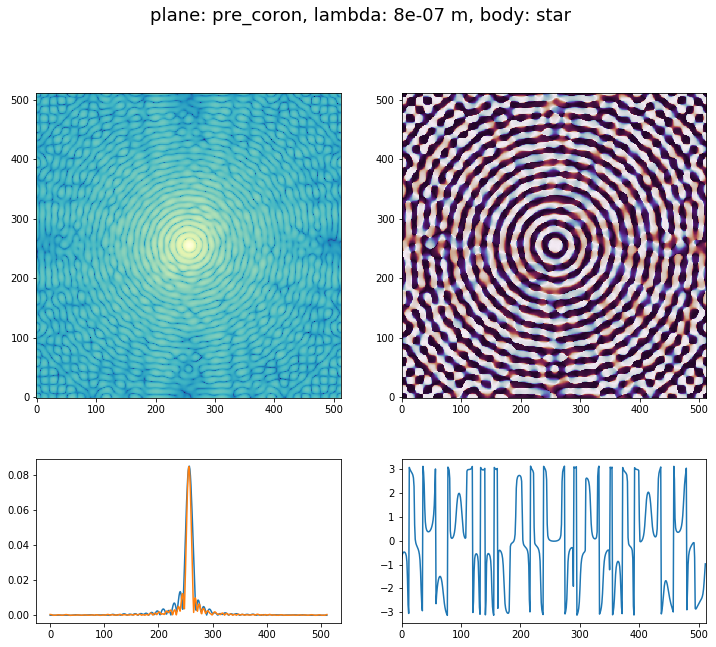

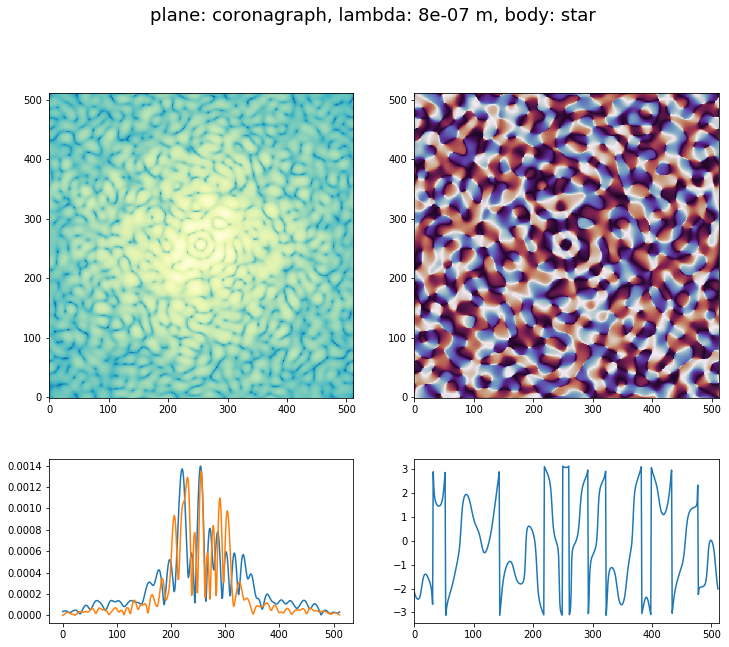

MEDIS++/medis/optics.py:176 - saving plane at detector
Finished datacube at timestep = 0


	MEDIS Telescope Run Completed

Time elapsed: 0.15 minutes
Shape of cpx_sequence = timesteps:1, save planes:2, wavelengths:1, num obj:2, x:512, y:512


In [42]:
observation = sim()

This demonstration shows reflections in the focal plane at wide separation which woould be reduced with an increase in grid_size and decrease in beam_ratio if neccessary.

From this dictionary we can look at the fields ndarray

dict_keys(['fields', 'sampling'])


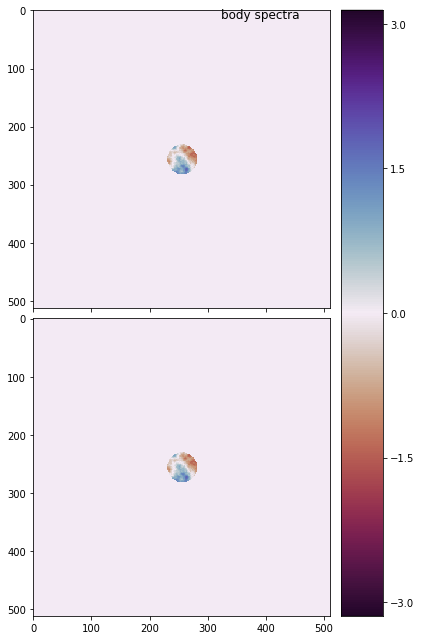

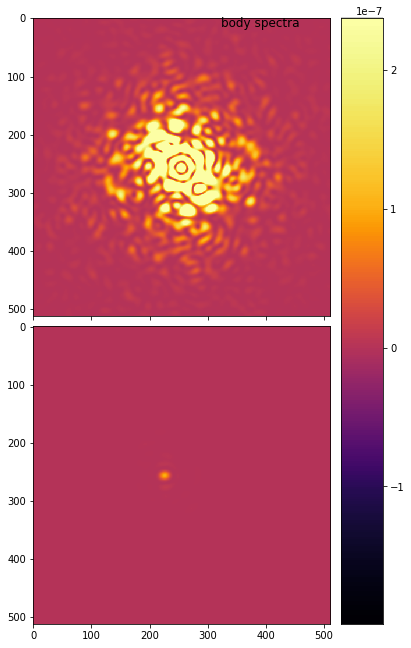

In [44]:
print(observation.keys())
fields = observation['fields']
grid(np.angle(fields[0,0]), vlim=(-np.pi, np.pi), show=False, cmap='sunlight')
grid(fields[0,1], logZ=True, nstd=2, show=True)

### Quantization

Now lets repeat the process but use the product == 'photons' option for RunMedis 

In [34]:
params['sp'].debug = False  # we already know what the planes look like now
params['sp'].save_to_disk = True  # save fields and save photons so they can be loaded
params['ap'].star_flux = 1e9  # lets assume 1e9 photons across the array per second
params['mp'].platescale = 10 *1e-3 # 10mas/pix
params['mp'].array_size = np.array([100,100])  # this will take the center 100*10mas of the input image
params['sp'].numframes = 20 # 20 * 0.5 ms = 10 ms of photon data
sim = RunMedis(params=params, name=f'{TESTDIR}/photonlist', product='photons')


	 Astro_params
{'C_spec': 1.5,
 'companion': True,
 'companion_xy': [[0.5, 0]],
 'contrast': [0.001],
 'interp_wvl': True,
 'n_wvl_final': 1,
 'n_wvl_init': 1,
 'star_flux': 1000000000.0,
 'wvl_range': array([8.0e-07, 1.5e-06])}

	 Telescope_params
{'abertime': 0.5,
 'ao_act': 50,
 'array_size': array([129, 129]),
 'cg_size': 3,
 'cg_size_units': 'l/D',
 'cg_type': 'Solid',
 'detector': 'ideal',
 'entrance_d': 5,
 'fit_dm': True,
 'fl_cg_lens': 1000,
 'flen_primary': 25,
 'fnum_primary': 12,
 'legs_frac': 0.03,
 'lens_params': [{'aber_vals': [5e-18, 2.0, 3.1],
                  'diam': 0.2,
                  'dist': 1.345,
                  'focal_length': 1.2,
                  'name': 'CPA'},
                 {'aber_vals': [5e-18, 2.0, 3.1],
                  'diam': 0.2,
                  'dist': 1.345,
                  'focal_length': 1.2,
                  'name': 'NCPA'}],
 'lyot_size': 0.75,
 'obscure': False,
 'piston_error': False,
 'pix_shift': [0, 0],
 'prescription': 'gen

This will create a new folder with a new fields ndarray (this time with more timesteps) and generate photons from it

In [35]:
observation = sim()
print(observation.keys(), observation['photons'].shape, observation['stackcube'].shape)


Initialising new telescope instance

Using prescription /Users/dodkins/PythonProjects/MEDIS++/simulations/general_telescope/general_telescope.py
Copying over prescription /Users/dodkins/PythonProjects/MEDIS++/simulations/general_telescope/general_telescope.py
MEDIS++/medis/atmosphere.py:32 - Making New Atmosphere Model
MEDIS++/medis/atmosphere.py:68 - atmos file = /Users/dodkins/MKIDSim/demo/photonlist/atmos/gridsz512_bmratio0.1_tsteps20/atmos_t0.000_single_wvl8.000e-07.fits
MEDIS++/medis/atmosphere.py:68 - atmos file = /Users/dodkins/MKIDSim/demo/photonlist/atmos/gridsz512_bmratio0.1_tsteps20/atmos_t0.001_single_wvl8.000e-07.fits
MEDIS++/medis/atmosphere.py:68 - atmos file = /Users/dodkins/MKIDSim/demo/photonlist/atmos/gridsz512_bmratio0.1_tsteps20/atmos_t0.001_single_wvl8.000e-07.fits
MEDIS++/medis/atmosphere.py:68 - atmos file = /Users/dodkins/MKIDSim/demo/photonlist/atmos/gridsz512_bmratio0.1_tsteps20/atmos_t0.002_single_wvl8.000e-07.fits
MEDIS++/medis/atmosphere.py:68 - atmos fil

Zeroing outside the beam after atmosphere
MEDIS++/medis/optics.py:176 - saving plane at atmosphere
Zeroing outside the beam after CPA
Zeroing outside the beam after deformable mirror
Zeroing outside the beam after NCPA
MEDIS++/medis/optics.py:176 - saving plane at detector
Finished datacube at timestep = 4
MEDIS++/medis/atmosphere.py:104 - Atmos map applied is /Users/dodkins/MKIDSim/demo/photonlist/atmos/gridsz512_bmratio0.1_tsteps20/atmos_t0.003_single_wvl8.000e-07.fits
MEDIS++/medis/atmosphere.py:104 - Atmos map applied is /Users/dodkins/MKIDSim/demo/photonlist/atmos/gridsz512_bmratio0.1_tsteps20/atmos_t0.003_single_wvl8.000e-07.fits
Zeroing outside the beam after atmosphere
MEDIS++/medis/optics.py:176 - saving plane at atmosphere
Zeroing outside the beam after CPA
Zeroing outside the beam after deformable mirror
Zeroing outside the beam after NCPA
MEDIS++/medis/optics.py:176 - saving plane at detector
Finished datacube at timestep = 5
MEDIS++/medis/atmosphere.py:104 - Atmos map appl

Zeroing outside the beam after atmosphere
MEDIS++/medis/optics.py:176 - saving plane at atmosphere
Zeroing outside the beam after CPA
Zeroing outside the beam after deformable mirror
Zeroing outside the beam after NCPA
MEDIS++/medis/optics.py:176 - saving plane at detector
Finished datacube at timestep = 17
MEDIS++/medis/atmosphere.py:104 - Atmos map applied is /Users/dodkins/MKIDSim/demo/photonlist/atmos/gridsz512_bmratio0.1_tsteps20/atmos_t0.009_single_wvl8.000e-07.fits
MEDIS++/medis/atmosphere.py:104 - Atmos map applied is /Users/dodkins/MKIDSim/demo/photonlist/atmos/gridsz512_bmratio0.1_tsteps20/atmos_t0.009_single_wvl8.000e-07.fits
Zeroing outside the beam after atmosphere
MEDIS++/medis/optics.py:176 - saving plane at atmosphere
Zeroing outside the beam after CPA
Zeroing outside the beam after deformable mirror
Zeroing outside the beam after NCPA
MEDIS++/medis/optics.py:176 - saving plane at detector
Finished datacube at timestep = 18
MEDIS++/medis/atmosphere.py:104 - Atmos map ap

The simulation produced 100000 photons with 20 time samples, 1 wavelength sample on a 100 by 100 array

observation['stackcube'] is already in nice format for viewing. Lets plot every 5th timestep

/Users/dodkins/.conda/envs/mmedis/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


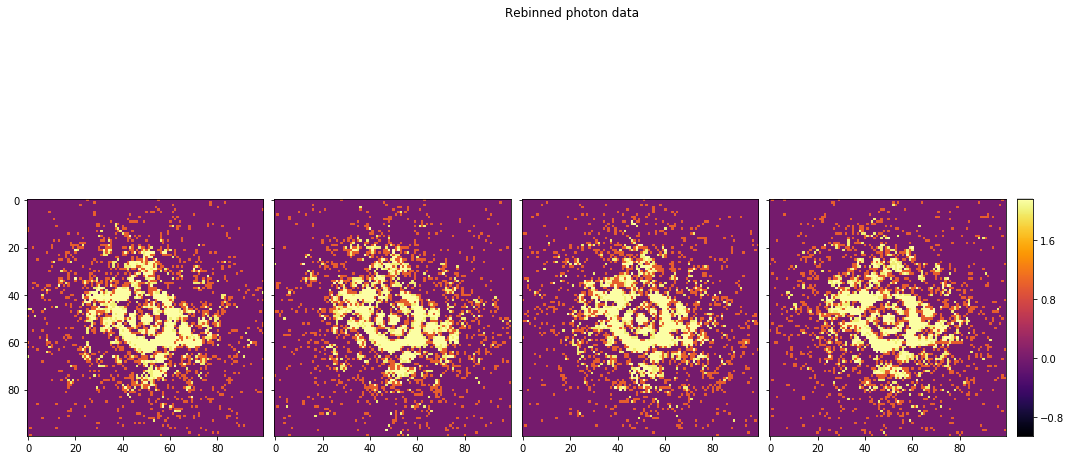

In [36]:
grid(observation['stackcube'][::5], show=True, title='Rebinned photon data')